In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.colors import ListedColormap

In [2]:
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
rng = np.random.RandomState(15082018)

In [4]:
X_train = np.loadtxt('Train/X_train.txt')
y_train = np.loadtxt('Train/y_train.txt')

In [5]:
with open('features.txt') as inputFileHandle:
    feautures = inputFileHandle.read().split('\n')
    
f = [i.replace(' ', '').replace("'", '') for i in feautures][:-1]

In [6]:
df_train = pd.DataFrame(X_train, columns = f)
df_train['labels'] = y_train

In [7]:
cmap = ListedColormap(sns.color_palette("hls", 8).as_hex())
diverging_cmap = ListedColormap(sns.color_palette("RdBu_r", 7).as_hex())

### Visualization
#### Umap rapresentation

In [8]:
from umap import UMAP
df_f = df_train.drop('labels', axis = 1)

In [9]:
embedded_umap = UMAP().fit_transform(df_f)

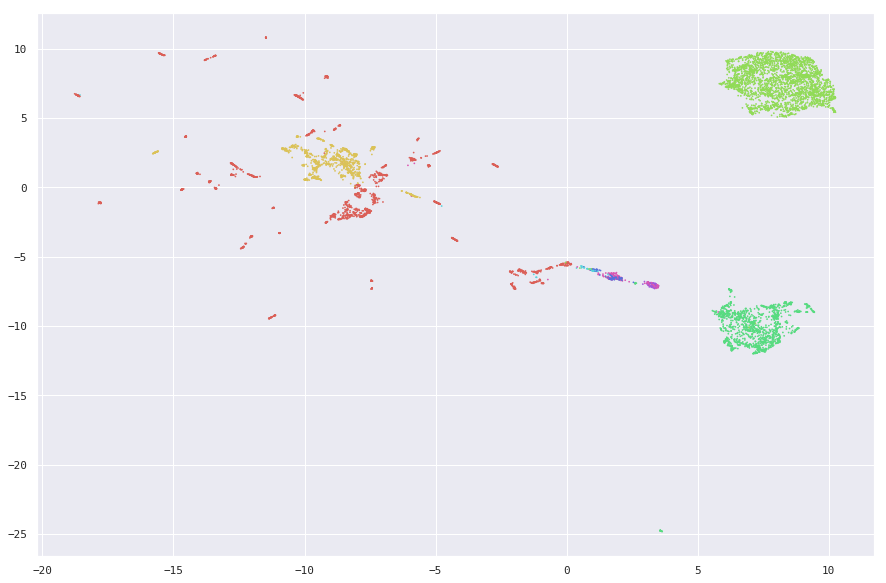

In [10]:
def plt_embedded(embedded):
    plt.figure(figsize = (15,10))
    x, y = embedded[:,0], embedded[:,1]
    plt.scatter(x, y, c=df_train['labels'], s= 0.5, cmap = cmap)
    plt.show()

plt_embedded(embedded_umap)

#### pca rapresentation

In [11]:
from sklearn.decomposition import PCA

In [12]:
def pca_explained_variance(df):
    component_space = list(range(1,int(df.shape[1]*0.3), 5))
    variance = []
    for c in component_space:
        pca = PCA(n_components=c)
        pca_X = pca.fit_transform(df)
        variance.append(np.sum(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(10,10))
    plt.title('Proportion of variance explained')
    plt.plot(component_space, variance)
    plt.xlabel('components')
    plt.ylabel('variance')
    plt.show()

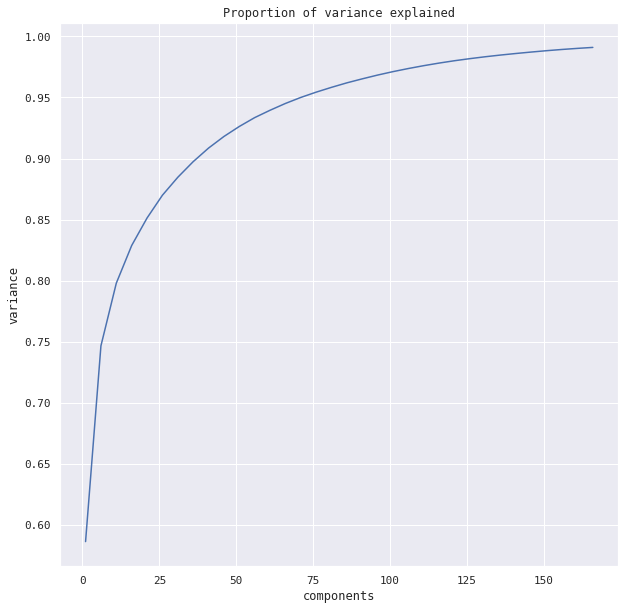

In [13]:
pca_explained_variance(df_f)

In [14]:
pca = PCA(n_components=75)
pca_X = pca.fit_transform(df_f)

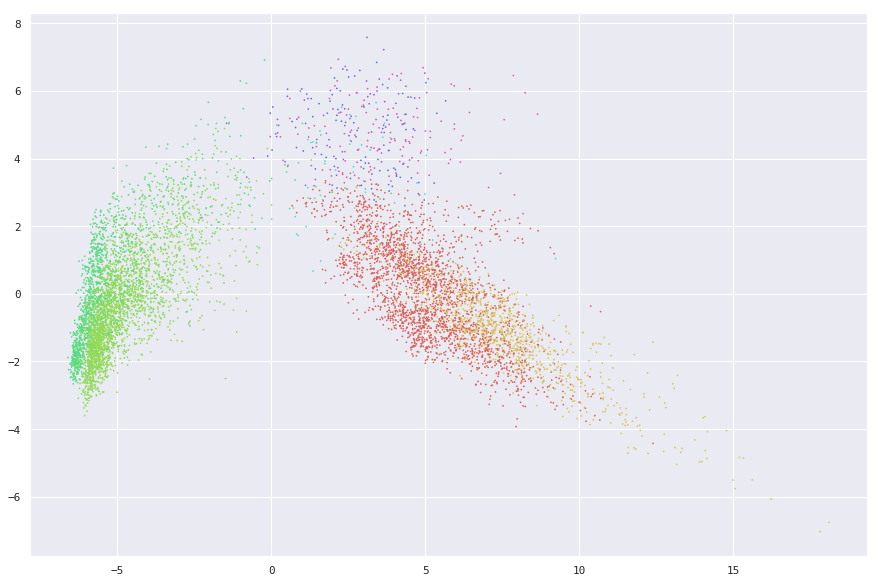

In [15]:
plt_embedded(pca_X)

#### Outliers detection

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
def mark_outliers(data):
    outlier_det = IsolationForest(max_features=10, n_estimators=200, random_state=rng, contamination=.05)
    outlier_det.fit(data)
    outliers = outlier_det.predict(data)
    
    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], c = outliers, cmap=diverging_cmap, s = 1)
    plt.show()
    
    
    return outliers, outlier_det

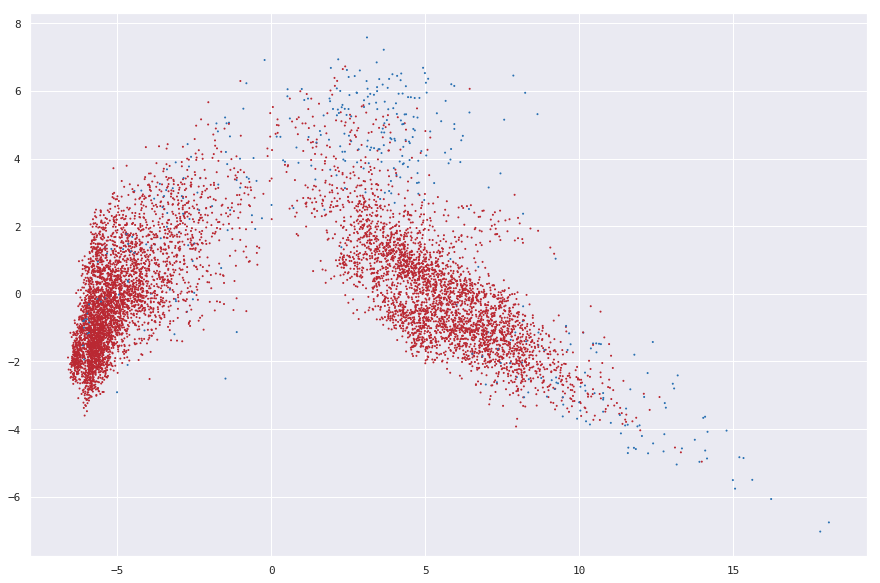

In [18]:
outliers, outlier_det = mark_outliers(pca_X)

#### Label distribution

In [19]:
from sklearn.utils.class_weight import compute_class_weight

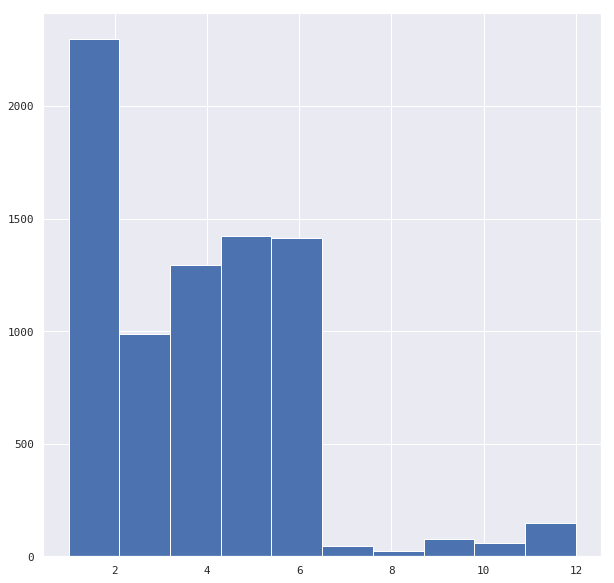

In [20]:
labels = df_train['labels']
plt.figure(figsize = (10,10))
labels.hist()
plt.show()

In [21]:
w = compute_class_weight('balanced', np.unique(labels), labels)

## Unsupervised

#### K-Means

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score

In [23]:
def kmeans(df_f, true_labels, clusters = list(range(2,18))):
    silhouette_scores = []
    rand_scores = []
    vscore = []
    for k in clusters:
        cls = KMeans(n_clusters=k, random_state=rng)
        
        cls.fit(df_f)
        pred_label = cls.predict(df_f)
        silhouette_scores.append(silhouette_score(df_f, pred_label, metric='cosine'))
        rand_scores.append(adjusted_rand_score(true_labels, pred_label))
        vscore.append(v_measure_score(true_labels, pred_label))
        
    
    results_df = pd.DataFrame({'clusters':clusters, 'sil':silhouette_scores, 'rand':rand_scores, 'V':vscore}).set_index('clusters')
    
    return results_df        

In [24]:
%%time

scores_df = kmeans(df_f, labels)

CPU times: user 2min 9s, sys: 9.85 s, total: 2min 19s
Wall time: 1min 36s


In [25]:
%%time

scores_df_pca = kmeans(pca_X, true_labels=labels)

CPU times: user 36.4 s, sys: 7.05 s, total: 43.5 s
Wall time: 38.2 s


In [26]:
%%time

scores_df_umap = kmeans(embedded_umap, true_labels = labels)

CPU times: user 13.4 s, sys: 2.61 s, total: 16 s
Wall time: 15.2 s


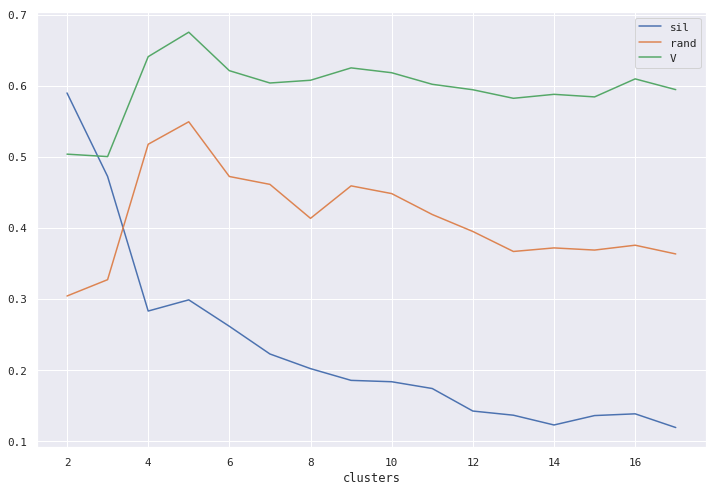

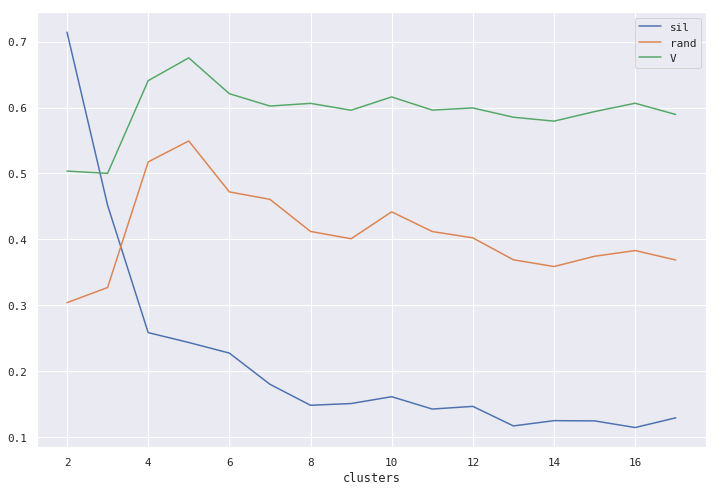

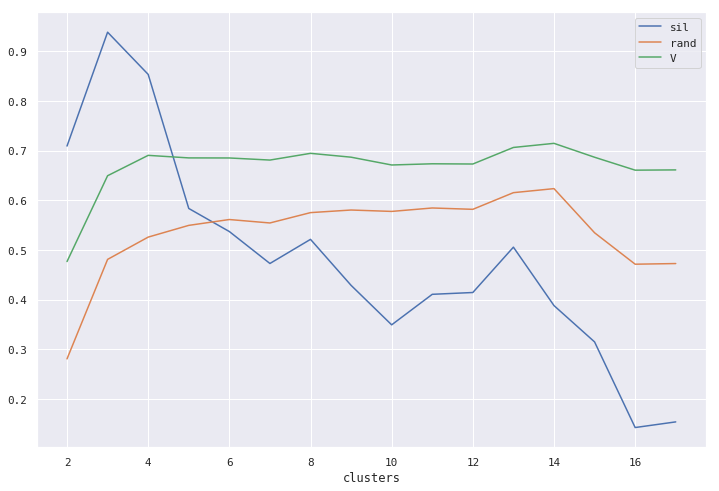

In [27]:
scores_df[['sil','rand', 'V']].plot(figsize = (12,8))
scores_df_pca[['sil', 'rand', 'V']].plot(figsize = (12,8))
scores_df_umap[['sil', 'rand', 'V']].plot(figsize = (12,8))

In [28]:
cls = KMeans(n_clusters=10, random_state=rng)
pred_labels = cls.fit_predict(embedded_umap)

In [29]:
df_kmeans = df_train.copy()
df_kmeans['kmeans'] = pred_labels

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
def cross_tab_heatmap(df, cluster_name = 'kmeans', true_labels = 'labels', label_relative = False):
    cross_tab = pd.crosstab(df_kmeans['kmeans'], df_kmeans['labels'])
    
    map_tab = cross_tab.copy()
    for col in map_tab.columns:
        map_tab[col] = map_tab[col].apply(lambda x: x/sum(map_tab[col]))
    
    heatmap = map_tab if label_relative else cross_tab
    plt.figure(figsize =(4*map_tab.shape[1],4*map_tab.shape[0]))
    sns.heatmap(heatmap, cmap=diverging_cmap, annot=True)
    plt.show
    
    return cross_tab, map_tab

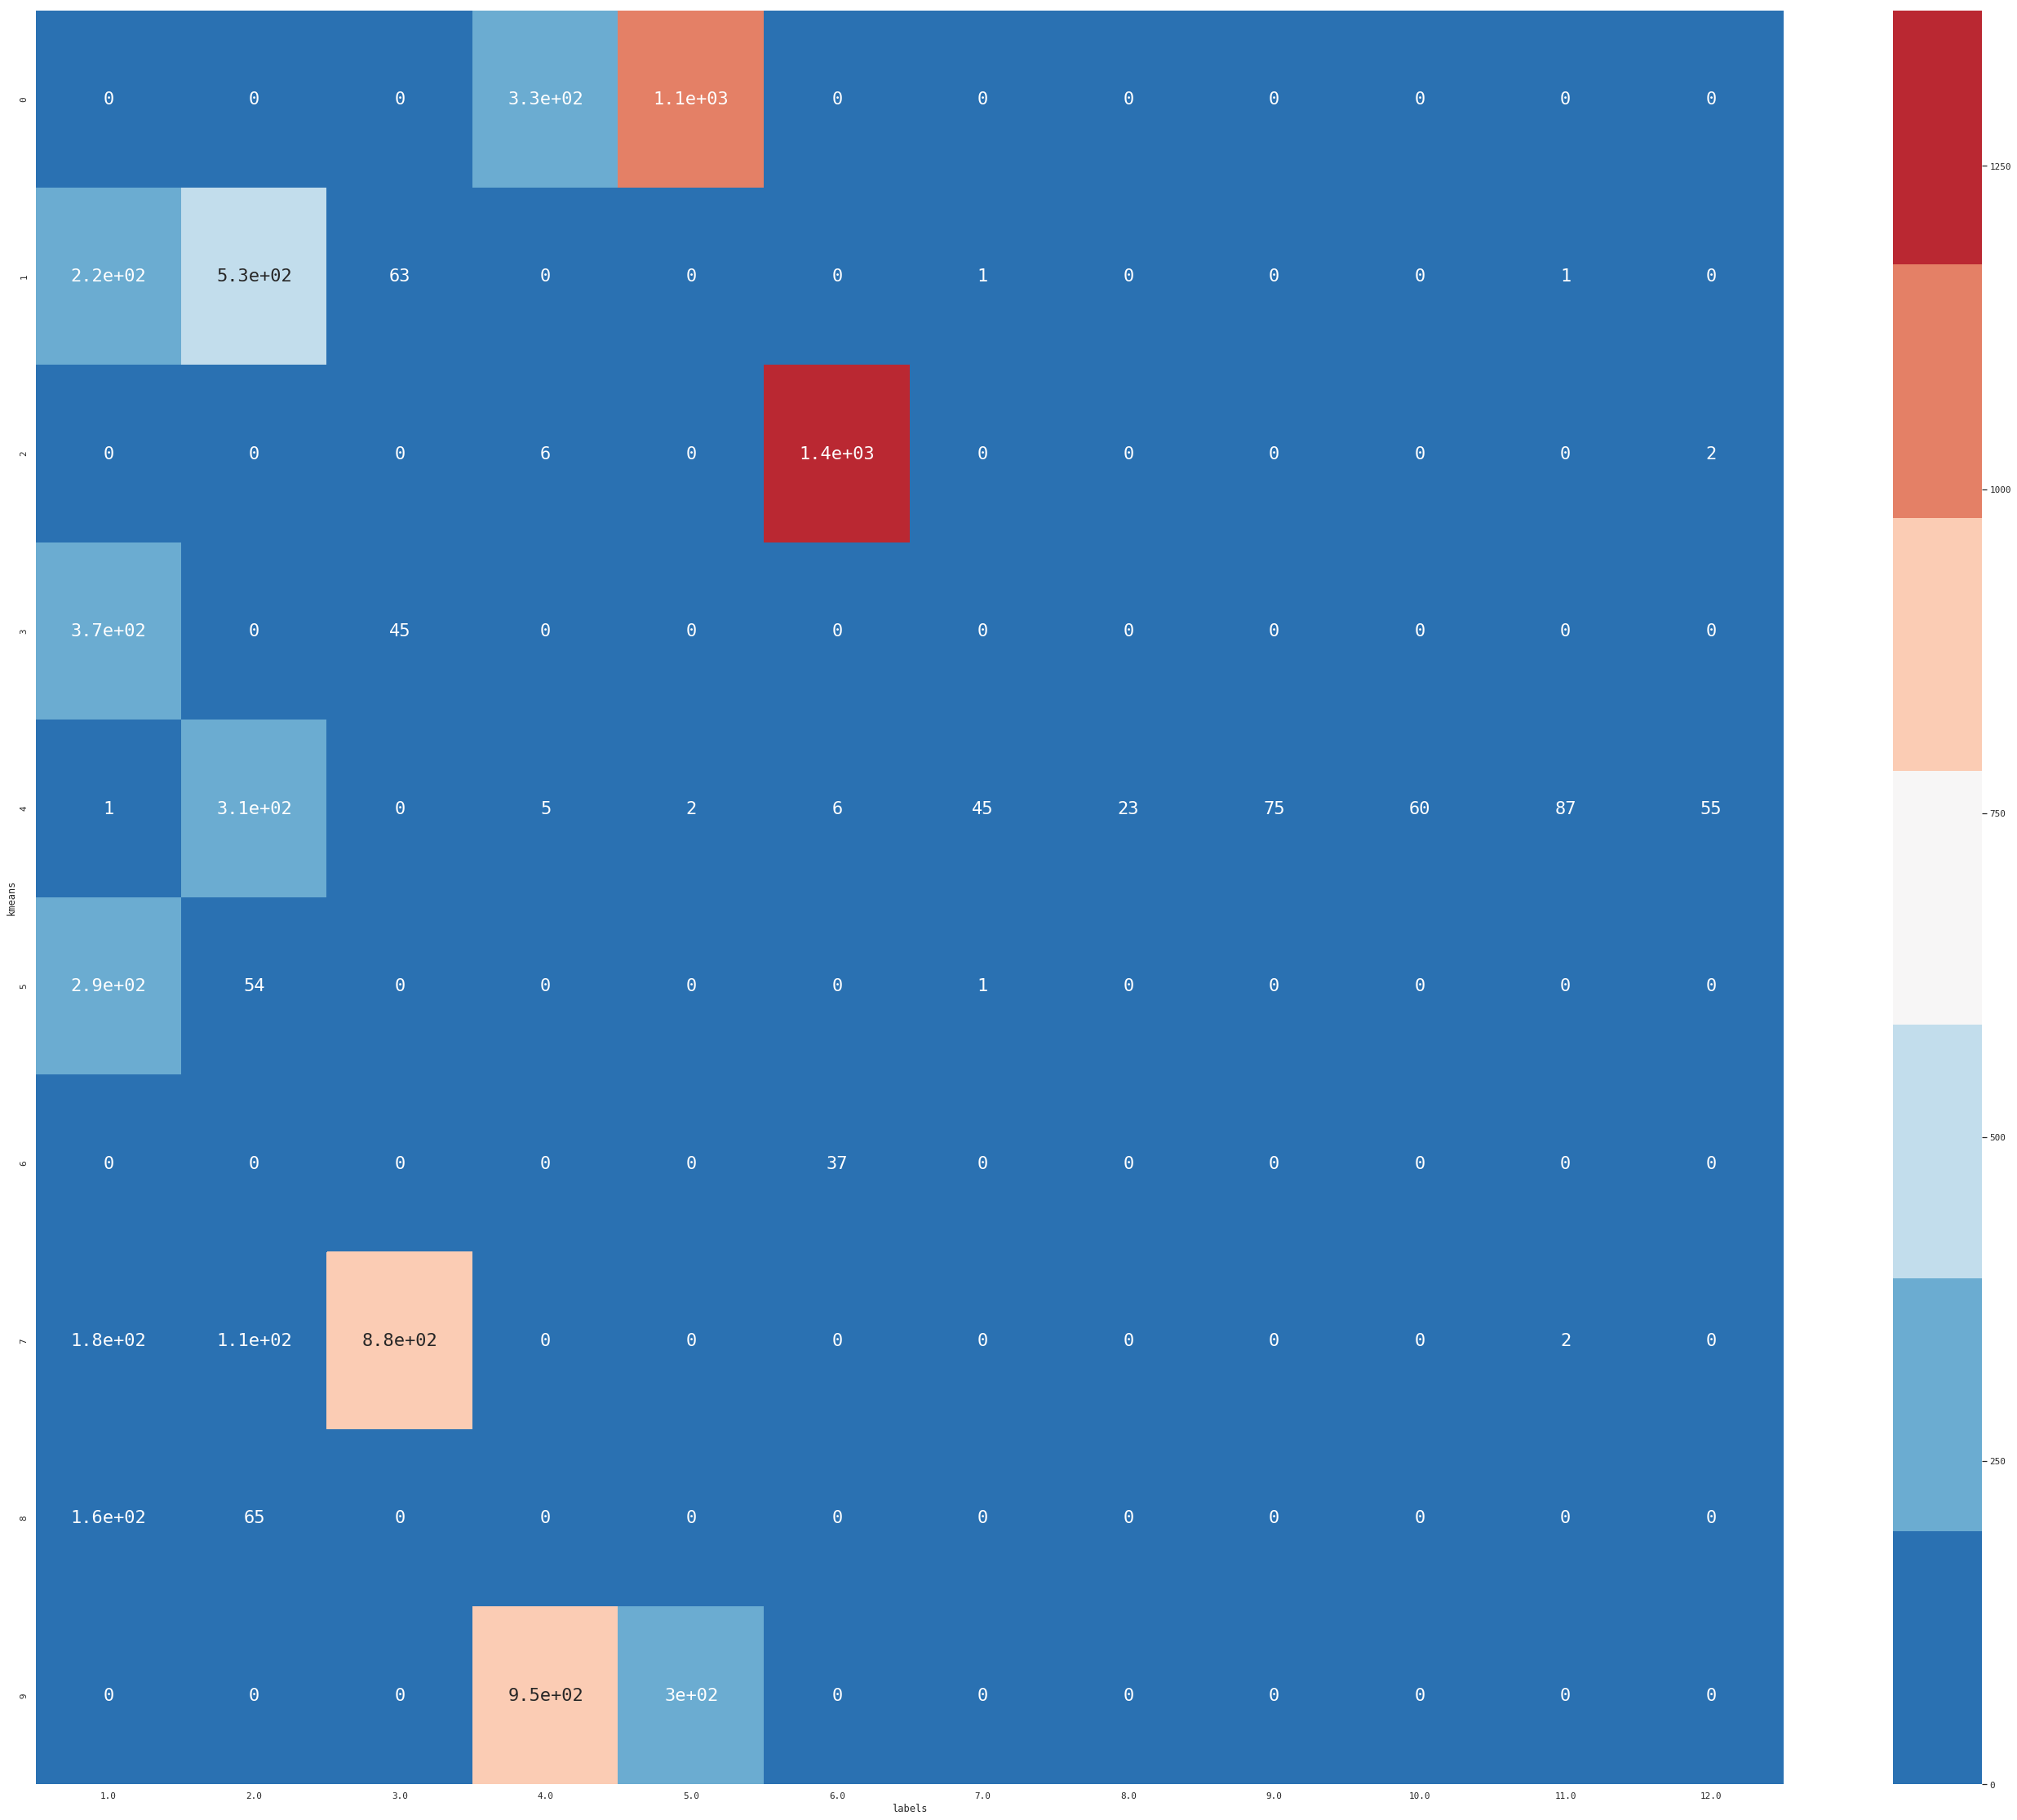

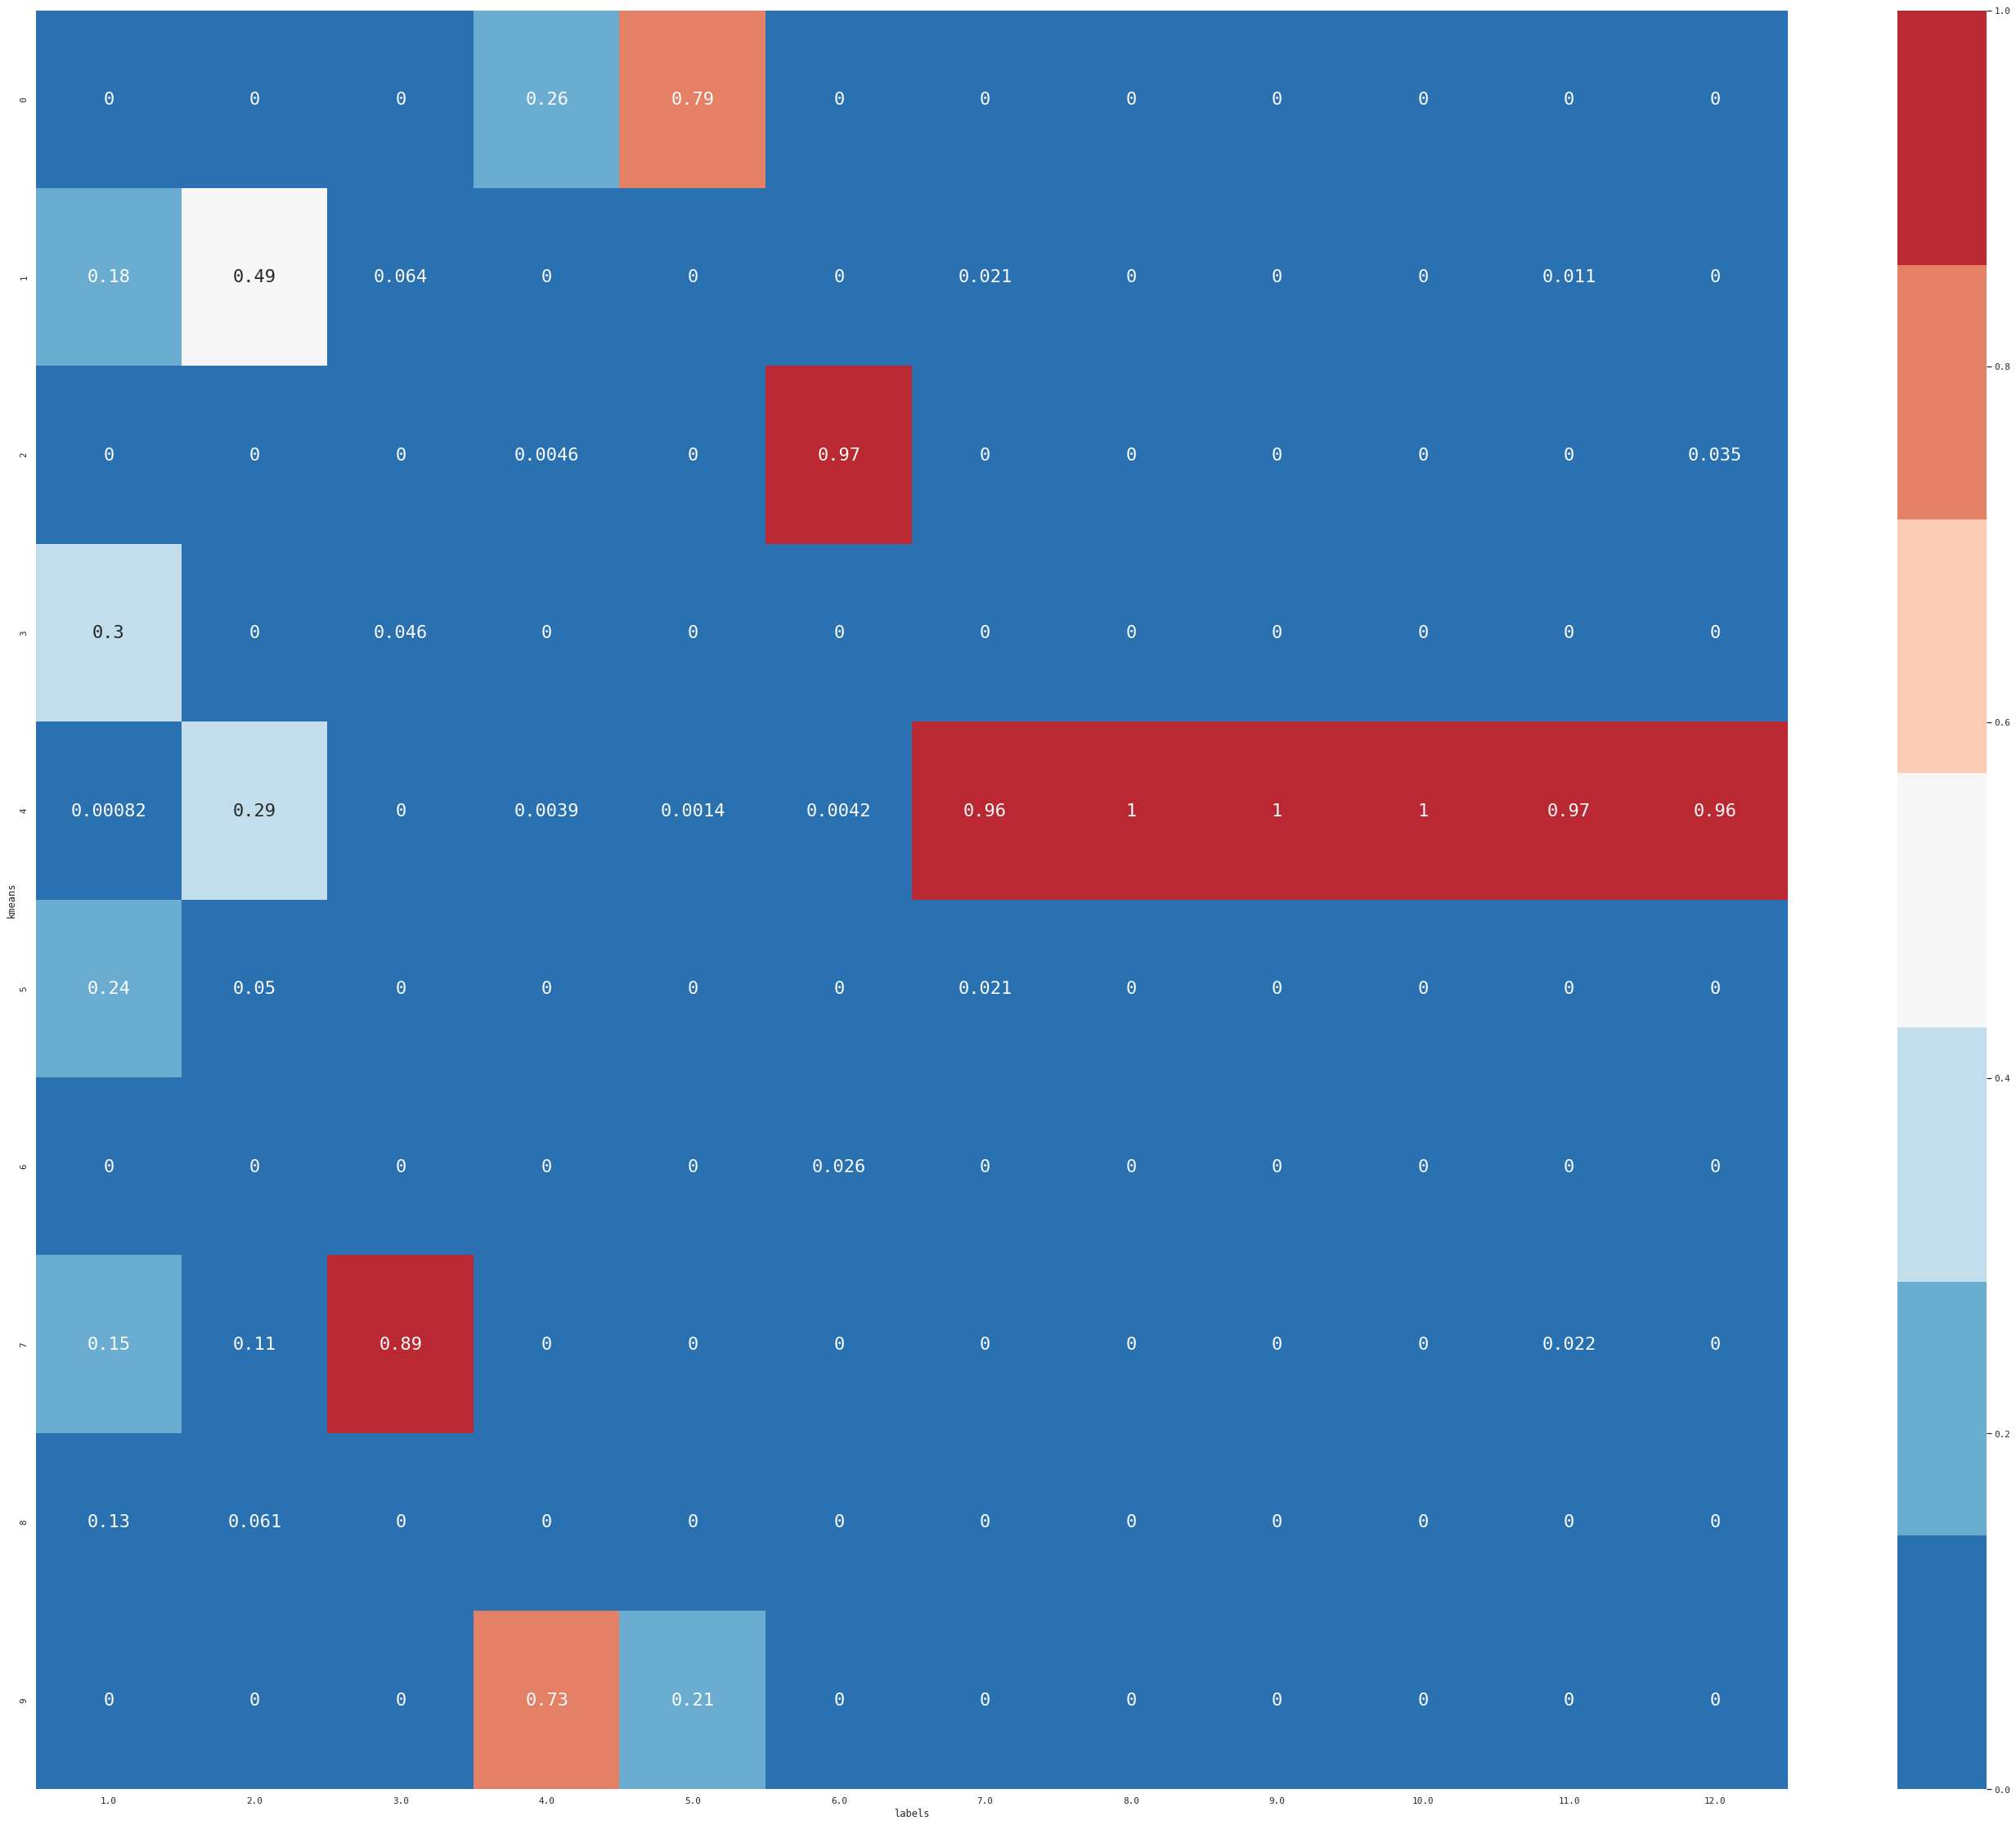

In [32]:
cross_tab, map_tab = cross_tab_heatmap(df_kmeans)
_,_ = cross_tab_heatmap(df_kmeans, label_relative=True)

#### DBSCAN

In [33]:
from sklearn.cluster import DBSCAN

In [34]:
def dbscan(df_f, true_labels, eps_space = np.arange(0.1,1.0,0.05), pca_data = False):
    if not pca_data:
        print('PCA...')
        scaler = StandardScaler()
        df_f = scaler.fit_transform(df_f)
        
    rand_scores = []
    vscore = []
    for eps in eps_space:
        cls = DBSCAN(eps=eps, min_samples=22)
        pred_label = cls.fit_predict(df_f)
        rand_scores.append(adjusted_rand_score(true_labels, pred_label))
        vscore.append(v_measure_score(true_labels, pred_label))
    
    results_df = pd.DataFrame({'eps':eps_space, 'rand':rand_scores, 'vscore':vscore}).set_index('eps')
    
    return results_df        

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
%%time 
dbscan_results_pca = dbscan(pca_X, labels, pca_data = True)

CPU times: user 15.5 s, sys: 145 ms, total: 15.6 s
Wall time: 15.6 s


In [37]:
%%time
dbscann_results_umap = dbscan(embedded_umap, labels, pca_data = True)

CPU times: user 1.48 s, sys: 36.6 ms, total: 1.52 s
Wall time: 1.52 s


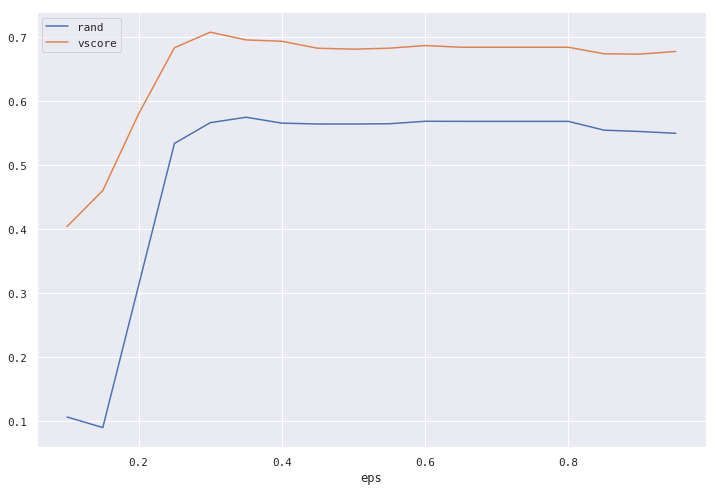

In [38]:
dbscann_results_umap[['rand', 'vscore']].plot(figsize = (12,8))

In [39]:
cls = DBSCAN(eps=0.3, min_samples=22)
dbscan_pred = cls.fit_predict(embedded_umap)

In [40]:
cmap_dbscan = ListedColormap(sns.color_palette("hls", len(set(dbscan_pred))).as_hex())


In [41]:
df_dbscan = df_train.copy()
df_dbscan['db_labels'] = dbscan_pred

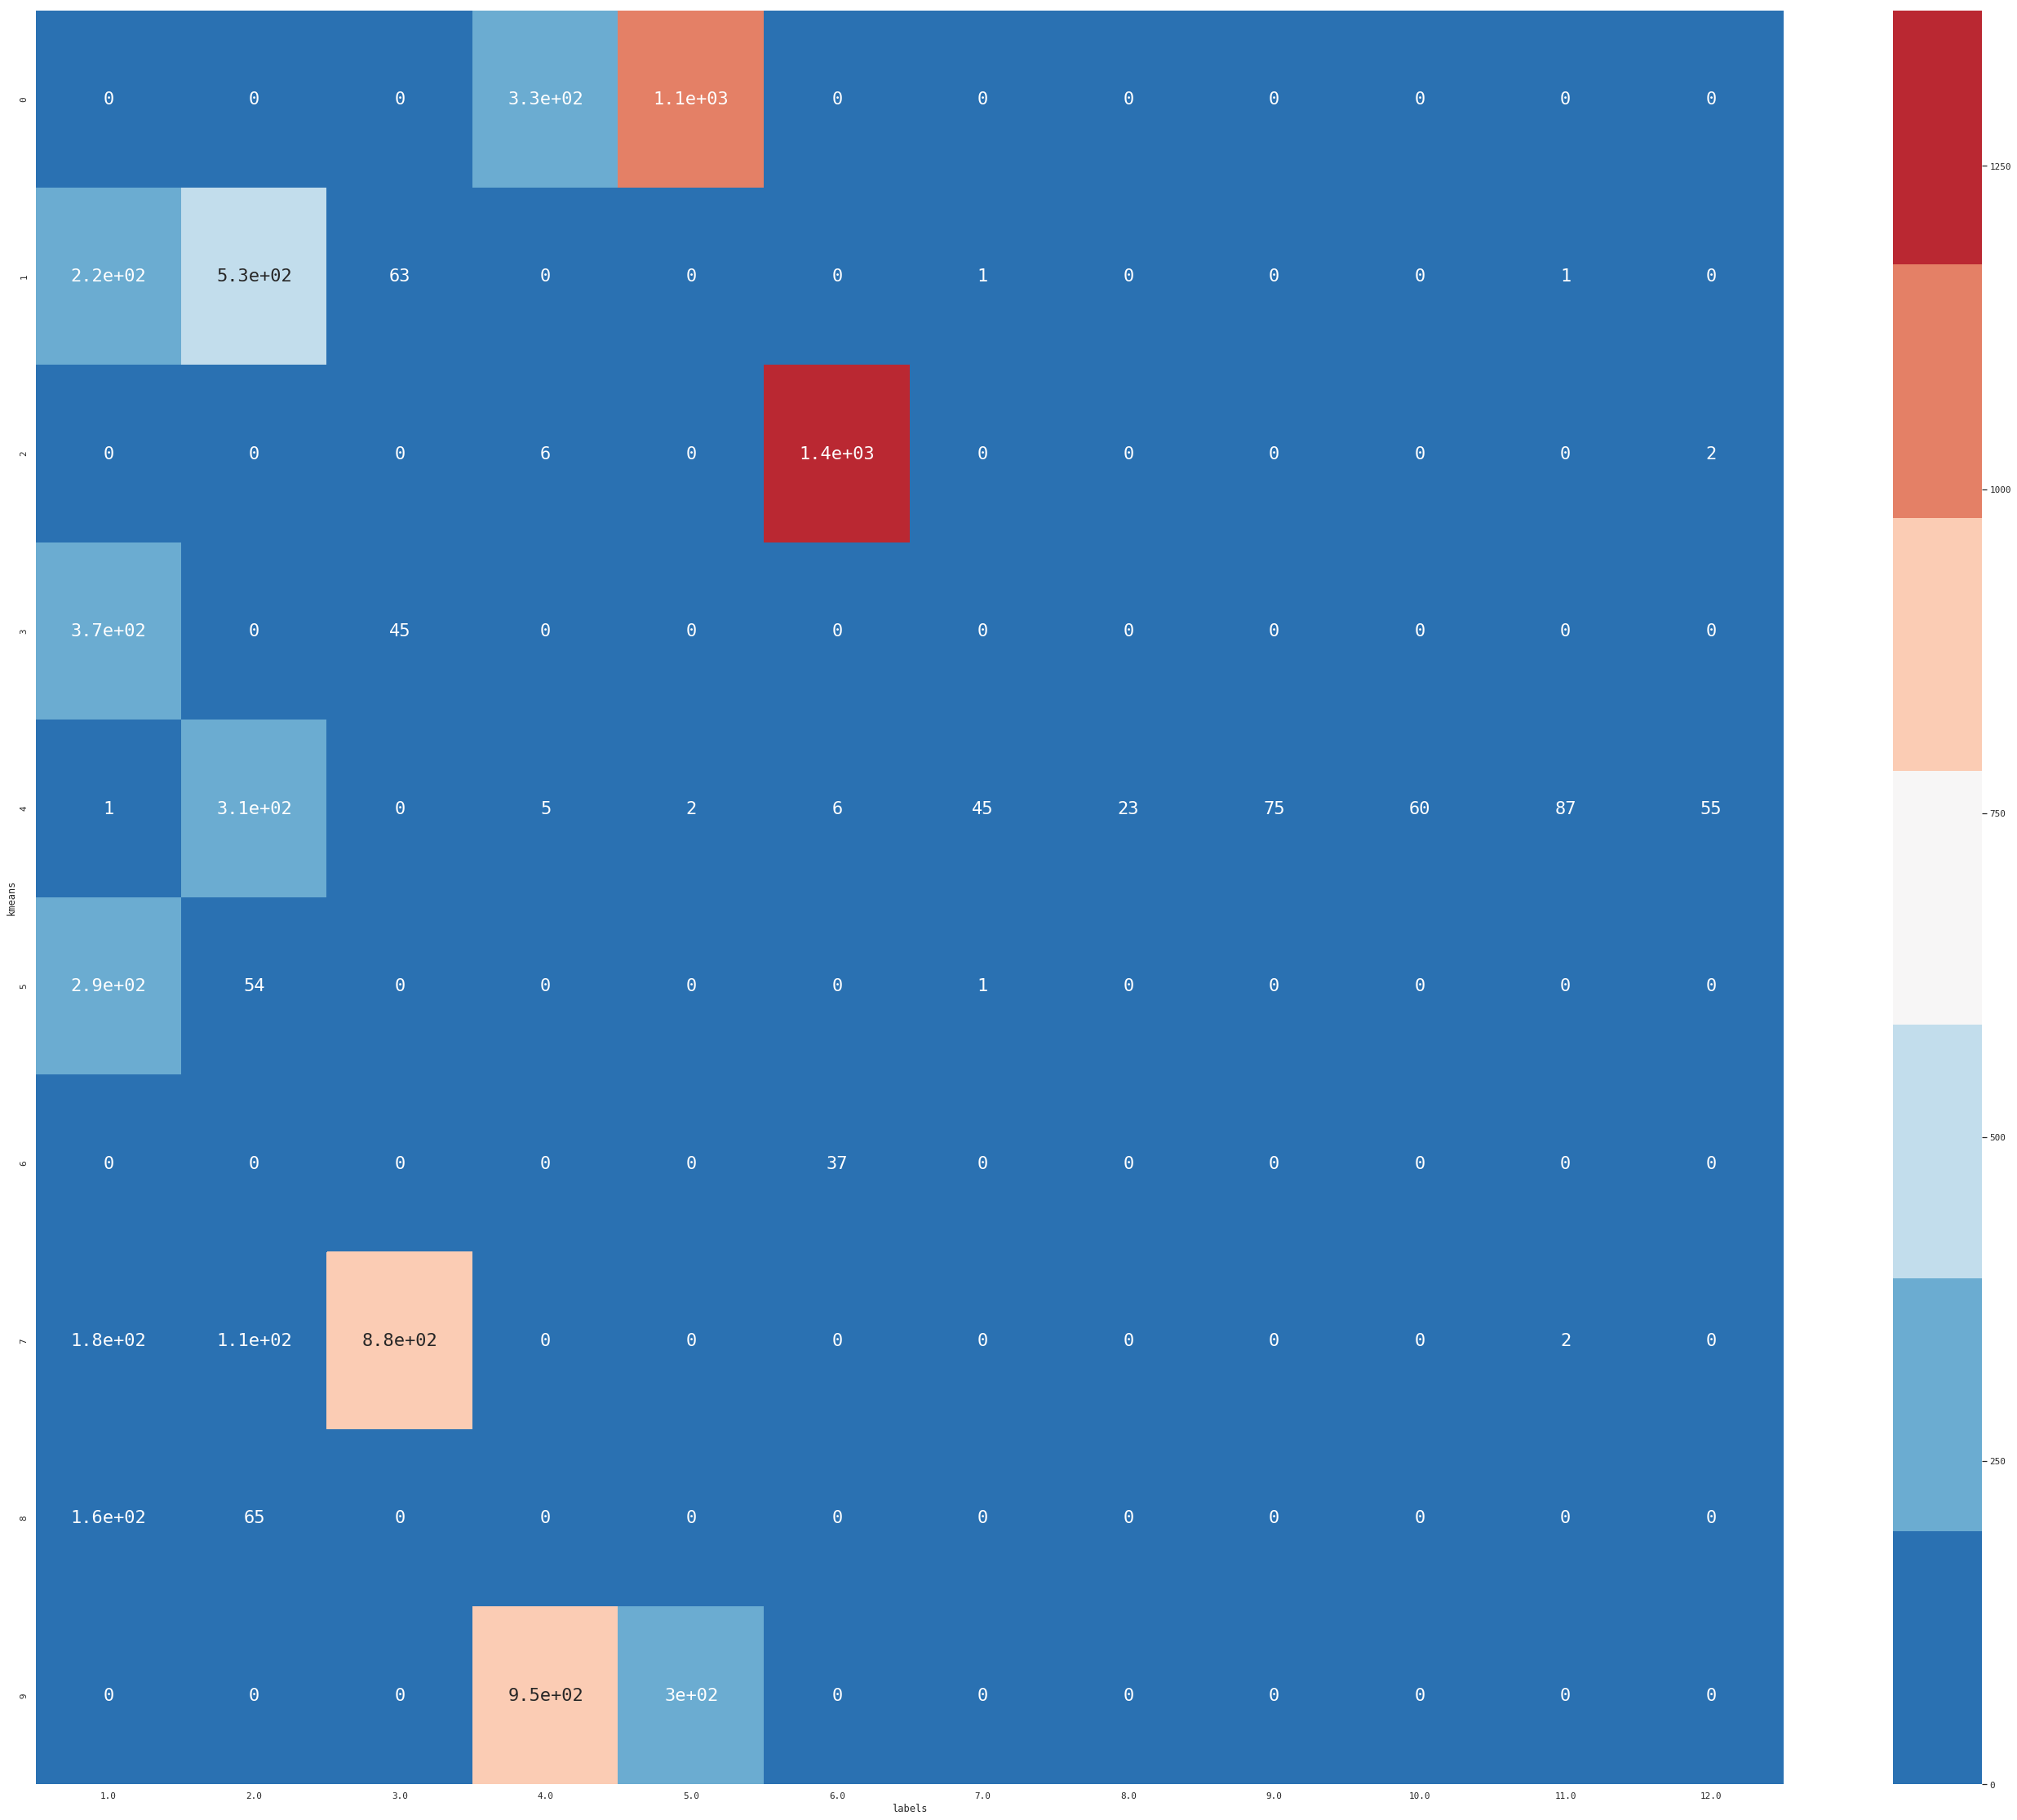

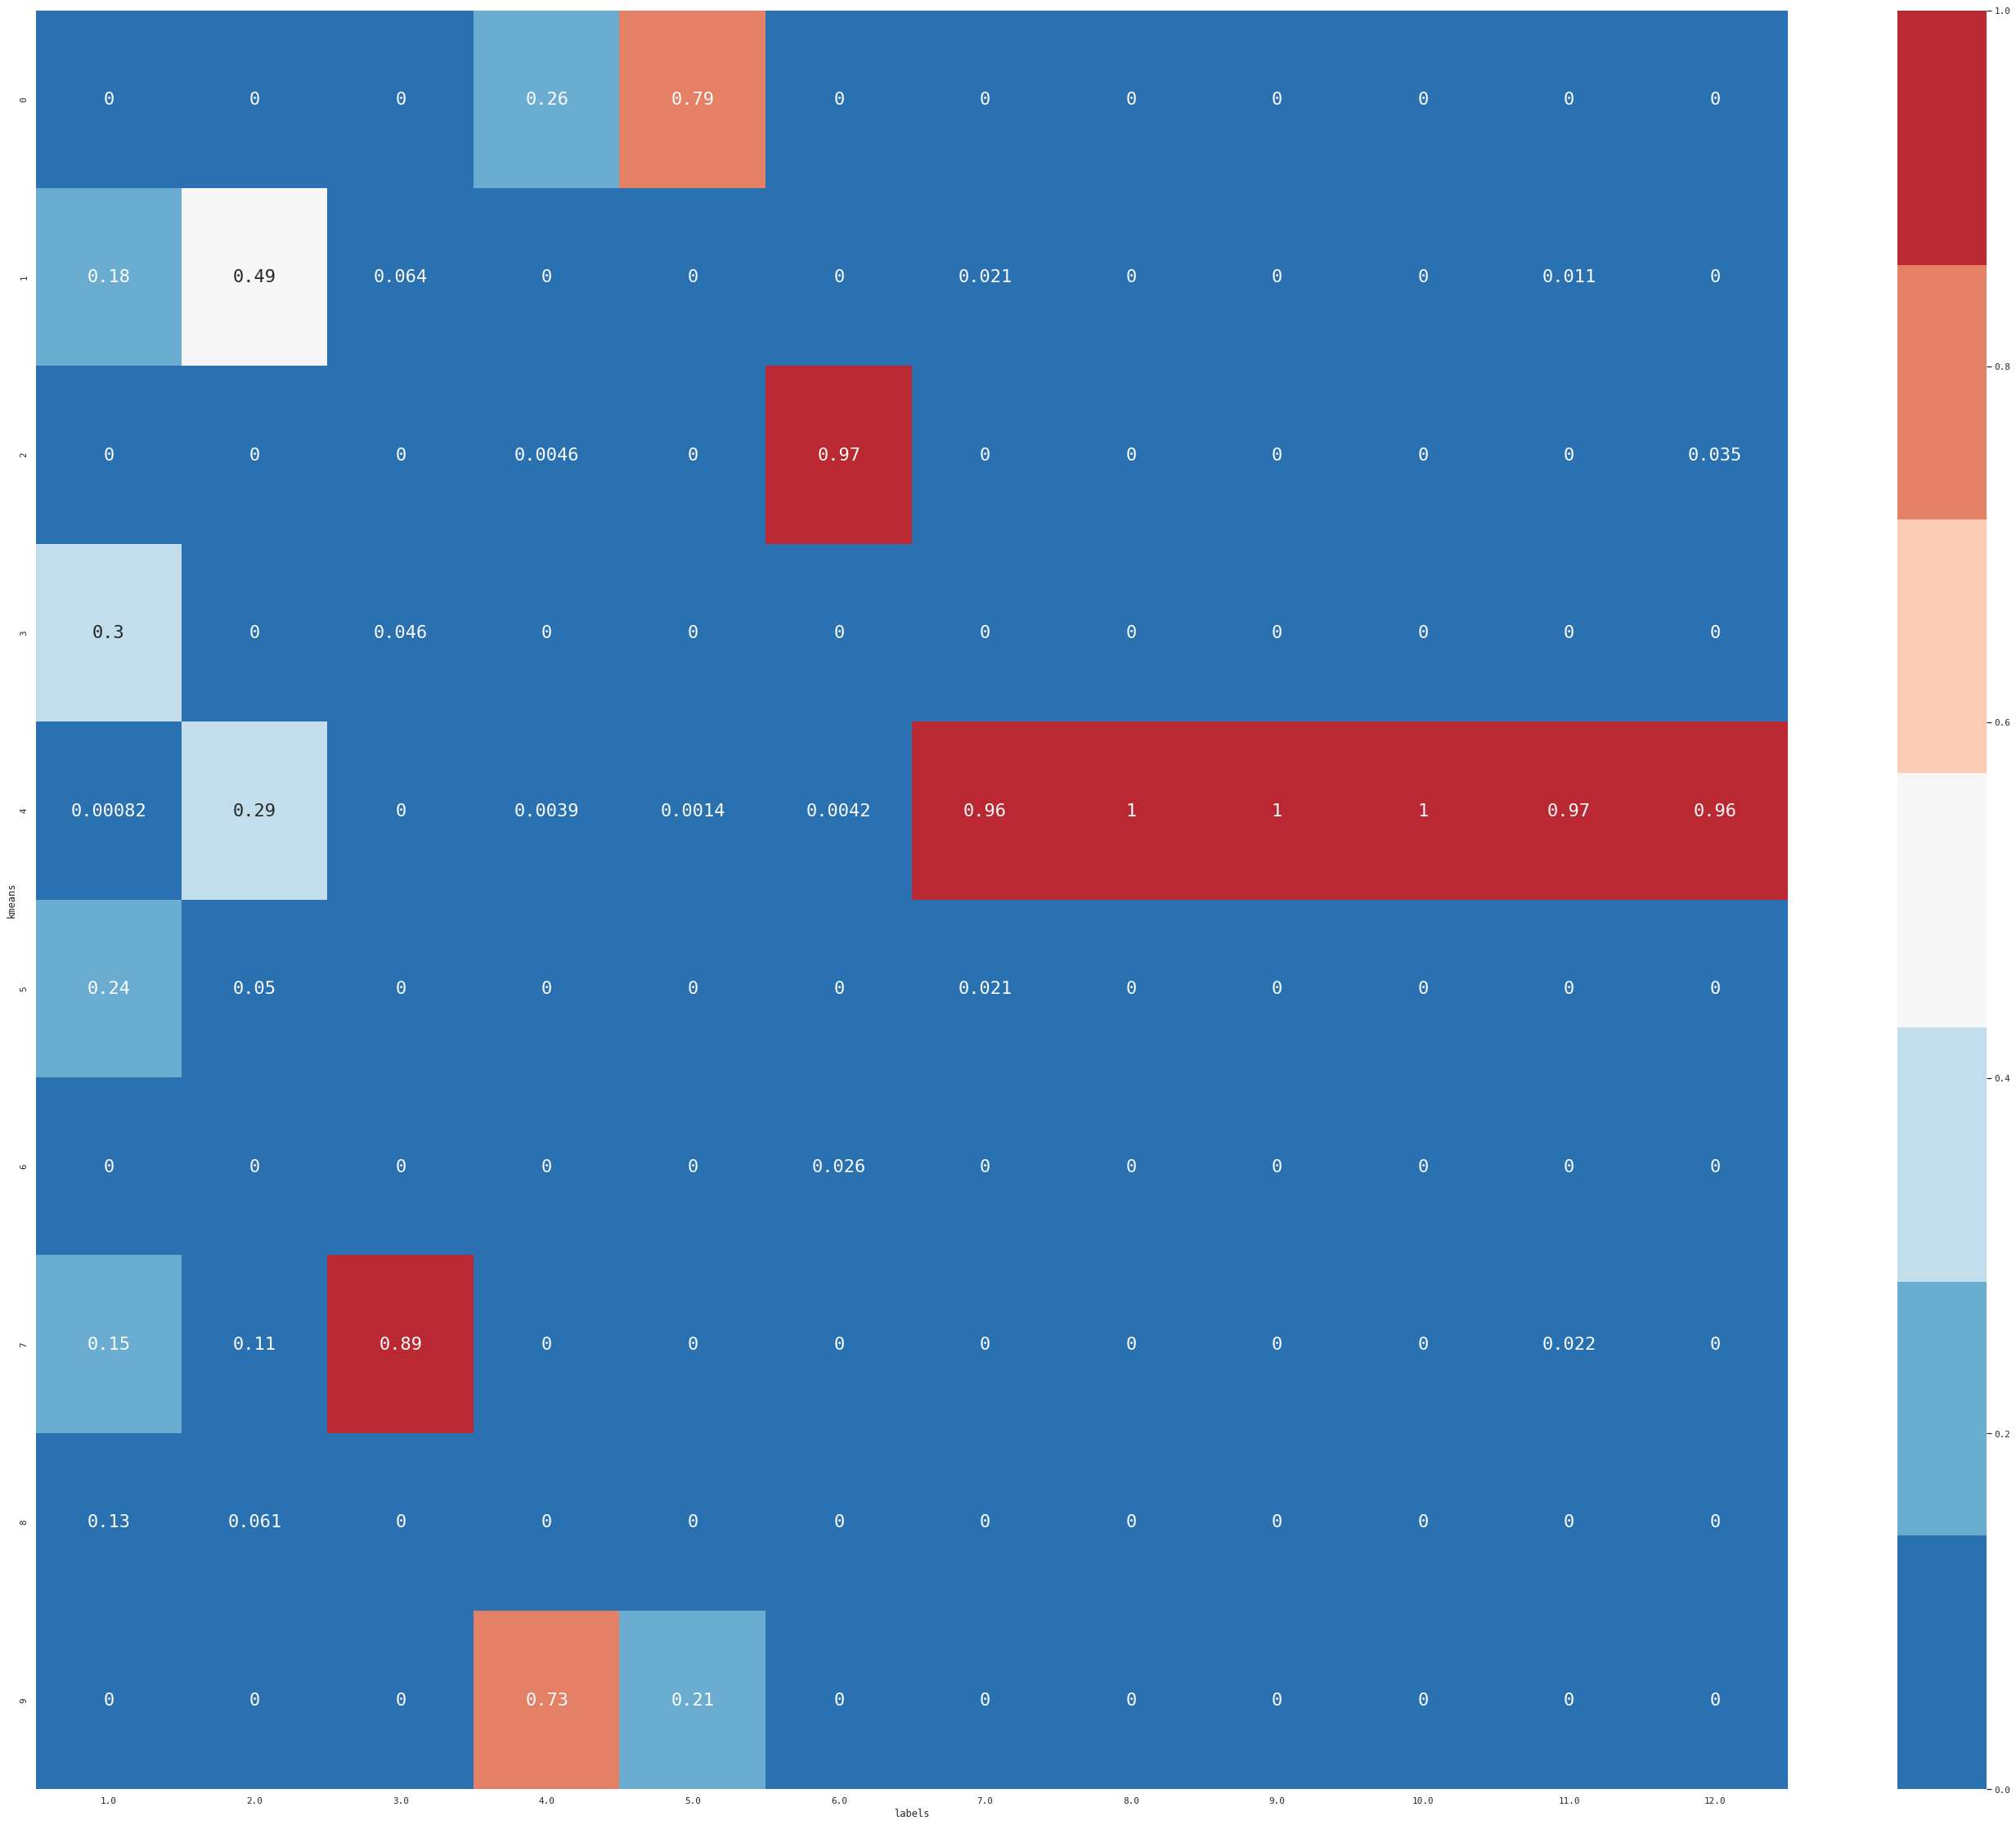

In [42]:
cross_tab, map_tab = cross_tab_heatmap(df_dbscan, cluster_name = 'db_labels')
_,_ = cross_tab_heatmap(df_dbscan,cluster_name = 'db_labels', label_relative=True)

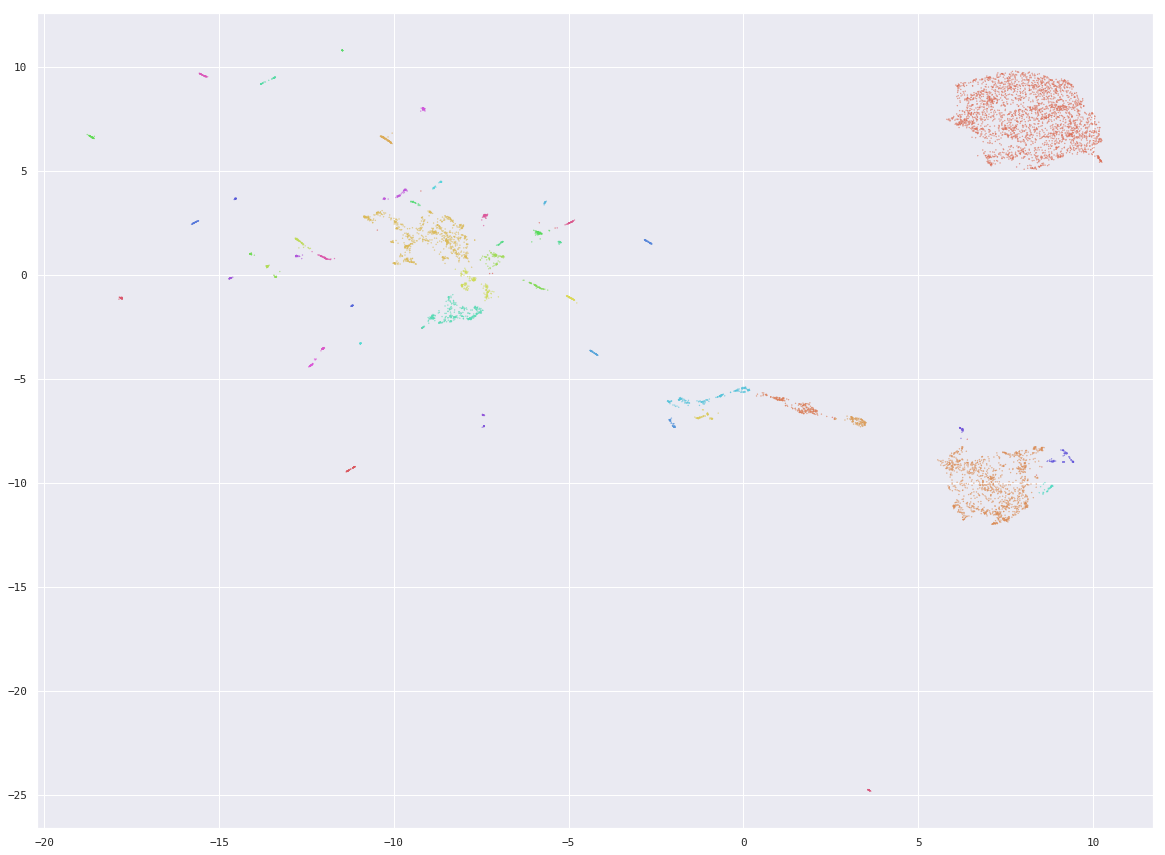

In [43]:
plt.figure(figsize = (20,15))
plt.scatter(embedded_umap[:,0], embedded_umap[:,1], c = dbscan_pred, cmap = cmap_dbscan, s = 0.1)
plt.show()

### HDBSCAN learning

In [50]:
raw_data = {
            'X_train': np.loadtxt('Train/X_train.txt'),
            'y_train': np.loadtxt('Train/y_train.txt').reshape(-1,1),
            'X_test': np.loadtxt('Test/X_test.txt'),
            'y_test': np.loadtxt('Test/y_test.txt').reshape(-1,1),
        }

In [47]:
import sys
sys.path.append('python_ian_utils')

from dataclass.embed_data import EmbeddedData

In [48]:
def hdb(X_train, X_test, y_train, y_test):

    cluster = hdbscan.HDBSCAN(min_cluster_size = 4, prediction_data=True, min_samples=22)
    cluster.fit(X_train)
    prediction, strenghts = hdbscan.approximate_predict(clusterer = cluster, points_to_predict = X_test)
    
    cmat = confusion_matrix(y_test, prediction)
    
    return prediction, cmat, strenghts, X_train, X_test, y_train, y_test

In [57]:
for k, v in raw_data.items():
    print(v.shape)

(7767, 561)
(7767, 1)
(3162, 561)
(3162, 1)


In [51]:
%%time
emb = EmbeddedData(**raw_data)

IndexError: index 3420 is out of bounds for axis 0 with size 3162

In [52]:
%notify

<IPython.core.display.Javascript object>